
0.   Create subject 


1.   Flavor tasting order
    
  Creates order for flavor ratings

2.   Four flavor selection & learning A and Assoc. test A sequence generator

3.   Two flavor selection, learning B and Assoc. test B sequence generator & neuroeconomics sequence generator



# Script Prep.

In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive/')
  shared_drive_foldername = 'NUTRECON'
  root = '/content/drive/Shareddrives/{}/*'.format(shared_drive_foldername)
  print('Running Code in Colab')
except:
  root = 'D:/FV/Projects/NUTRECON/nutreconDrive/'
  print('Running Code locally')

import sys
sys.path.append(root + '1. Acquisition/current_version/notebooks')

from nutrecon import *

import numpy as np
from glob import glob
from datetime import datetime
import json

from random import shuffle, sample
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns

_v_ = Vars()

experiment_code = _v_.experiment_code
dataPath = _v_.dataPath
sequences_dataPath = _v_.sequences_dataPath
responses_dataPath = _v_.responses_dataPath

flavorCodes = _v_.flavorCodes

imageCodes = _v_.imageCodes

imageDecoder = _v_.imageDecoder

pres_order_fileID = _v_.pres_order_fileID
pres_order_colName = _v_.pres_order_colName
flavorName_colName = _v_.flavorName_colName
flavorID_colName = _v_.flavorID_colName

pres_order_d2_fileID = _v_.pres_order_d2_fileID
pres_order_d3_fileID = _v_.pres_order_d3_fileID

flav_ratings_fileID = _v_.flav_ratings_fileID

intensity_colName = _v_.intensity_colName
novelty_colName = _v_.novelty_colName
pleasanteness_colName = _v_.pleasanteness_colName

learn_order_fileID = _v_.learn_order_fileID
learningOrder_colName = _v_.learningOrder_colName
imageName_colName = _v_.imageName_colName
imageID_colName = _v_.imageID_colName

assocTestOrder1_colName = _v_.assocTestOrder1_colName
assoc1_order_fileID = _v_.assoc1_order_fileID

assocTestOrder2_colName = _v_.assocTestOrder2_colName
assoc2_order_fileID = _v_.assoc2_order_fileID

assocTestOrder3_colName = _v_.assocTestOrder3_colName
assoc3_order_fileID = _v_.assoc3_order_fileID

neuroEconOrder1_fileID = _v_.neuroEconOrder1_fileID
neuroEconOrder2_fileID = _v_.neuroEconOrder2_fileID

conditioning_order_fileID = _v_.conditioning_order_fileID
conditioning_order_colName = _v_.conditioning_order_colName


Running Code locally
Running Code locally


___

# 0. Create subject


In [2]:
subject_nr = 4

subject_code = '{}{:03d}'.format(experiment_code, subject_nr)

timestamp = datetime.now().timestamp()
print(subject_code)

nutre004


# 1. Flavor tasting order 

In [3]:
flavorList = list(flavorCodes.keys())
shuffle(flavorList)

presentation_order_list = [[p + 1, flavorList[p], flavorCodes[flavorList[p]]] for p in range(len(flavorList))]

presentation_order_df = pd.DataFrame(presentation_order_list, columns = [pres_order_colName, flavorName_colName, flavorID_colName]).set_index(pres_order_colName)
#presentation_order_json = presentation_order_df.to_dict('index')

presentation_order_df = save_json(presentation_order_df, subject_code, pres_order_fileID, sequences_dataPath)
presentation_order_df

File already exists. Created on 2022-12-14 10:11:48


,Flavor,flavor_id
Presentation Order,,
1,ginseng,i
2,cashew,c
3,pomegranate,e
4,grapefruit,j
5,blueberry,g
6,licorice,k
7,dragon fruit,h
8,lychee,d


# 2. Four flavor selection & learning A and Assoc. test A sequence generator

## 2.1 Flavor Ratings


In [7]:
pleas_min = 0
pleas_max = 80
df_pleas = None
df_pleas_ = None

ratings_colNames = ['User','Trial',novelty_colName, intensity_colName, pleasanteness_colName]
df_, _ = loadResponses(responses_dataPath, flav_ratings_fileID, subject_code)
if not df_ is None:

  df = presentation_order_df.reset_index().merge(df_[ratings_colNames],
                                  left_on = pres_order_colName, right_on = 'Trial').drop(columns='Trial')
  df_pleas = df[(df[pleasanteness_colName] >= pleas_min) & (df[pleasanteness_colName] < pleas_max)].sort_values(by=novelty_colName, ascending = False)
  if len(df_pleas) == 0 :
    df_pleas = df.sort_values(by=[pleasanteness_colName, novelty_colName], key=abs).set_index(np.arange(1,len(df)+1))
    df_pleas['criteria'] = 'not in complience'
  else:
    df_pleas['criteria'] = 'in complience'
    flavors_ = df_pleas[flavorName_colName].to_list()
    df_ = df[~df[flavorName_colName].isin(flavors_)].sort_values(by=[pleasanteness_colName, novelty_colName], key=abs)
    df_['criteria'] = 'not in complience'
    df_pleas = pd.concat([df_pleas, df_])
  df_pleas = df_pleas.set_index(np.arange(len(df_pleas)) + 1).rename_axis('').reset_index().set_index(['criteria', ''])
  df_pleas_ = df_pleas.drop(columns = ['User',pres_order_colName] )

df_pleas_

Flavor flavor_id  novelty  intensity  pleasantness
criteria                                                                     
in complience     1     blueberry         g       89         38            26
                  2   pomegranate         e       35          9             2
                  3       ginseng         i       17         16            28
                  4      licorice         k        6          3             3
                  5    grapefruit         j        2         16            38
not in complience 6        lychee         d       71         38           -10
                  7        cashew         c       82         39           -14
                  8  dragon fruit         h       93         69           -36

## 2.2 Learning Order

### Select four flavors below

In [8]:
four_flavors = ['j','g','i','e']   # CHANGE HERE

#===============================================================================

def get_key(my_dict, val):
    for key, value in my_dict.items():
        if val == value:
            return key
 
    return "key doesn't exist"

images = sample(imageCodes.keys(),4)

imageFlavor_list = [[get_key(flavorCodes, four_flavors[p]), 
                     imageCodes[images[p]],
                     four_flavors[p], images[p]] for p in range(len(four_flavors))]

imageFlavor_df = pd.DataFrame(imageFlavor_list, columns = [flavorName_colName, imageName_colName,
                                                           flavorID_colName, imageID_colName])
imageFlavor_df = imageFlavor_df.sample(frac= 1).reset_index(drop = True)
imageFlavor_df.index += 1
imageFlavor_df.index.name = learningOrder_colName

imageFlavor_df = save_json(imageFlavor_df, subject_code, learn_order_fileID, sequences_dataPath)
flavorImage_code = {p[imageID_colName]:p[flavorName_colName] for p in imageFlavor_df[[imageID_colName, flavorName_colName]].to_dict('index').values()}
imageFlavor_df.drop(columns = [flavorName_colName, imageName_colName])

File already exists. Created on 2022-12-14 11:27:28


C:\Users\Admin\AppData\Local\Temp\ipykernel_4288\2779766843.py:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  images = sample(imageCodes.keys(),4)


,flavor_id,image_id
Learning order,,
1,j,Image VI
2,g,Image I
3,e,Image V
4,i,Image II


## 2.3 Association Test A order

In [9]:
associationTest1_df = pd.concat([imageFlavor_df]*6).sample(frac = 1).reset_index(drop = 'False')
associationTest1_df.index += 1
associationTest1_df.index.name = assocTestOrder1_colName

associationTest1_df = save_json(associationTest1_df, subject_code, assoc1_order_fileID, sequences_dataPath)
associationTest1_df.drop(columns = [flavorName_colName, imageName_colName])

File already exists. Created on 2022-12-14 11:38:09


,flavor_id,image_id
Day 1 - Association Test order,,
1,i,Image II
2,j,Image VI
3,g,Image I
4,j,Image VI
5,e,Image V
6,e,Image V
7,i,Image II
8,j,Image VI
9,g,Image I


# 3. Two flavor selection & Assoc. test B  and neuroeconomics sequence generator

## 3.1 Flavor selection

			Accuracy: 0.9583333333333334


precision    recall  f1-score       Flavor
criteria      image_id flavor_id                                            
in compliance Image I  g           1.000000  1.000000  1.000000    blueberry
              Image VI j           1.000000  1.000000  1.000000   grapefruit
              Image II i           0.857143  1.000000  0.923077      ginseng
              Image V  e           1.000000  0.833333  0.909091  pomegranate

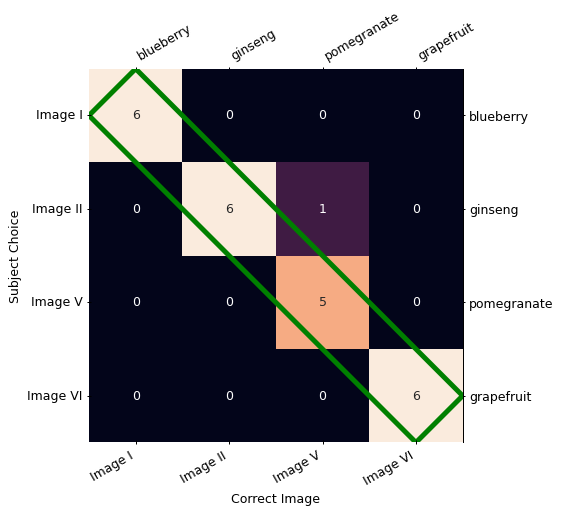

In [10]:
min_correctResp = 4

atest_day1_sequence = [get_key(imageDecoder,p) for p in associationTest1_df['image_id'].tolist()]
atest_day1_responses, _ = loadResponses(responses_dataPath, 'day1_atest', subject_code)

fig, report = reportAndConfusionMatrix(atest_day1_sequence, atest_day1_responses['image_id'].tolist(), flavorImage_code)
check_atest(report, flavorImage_code, min_correctResp)

### Select two flavors below

In [11]:
two_flavors = ['g', 'j']

#### Generate sequences for the rest od the expetiment

In [12]:
presentation_order_d2_df = imageFlavor_df[imageFlavor_df['flavor_id'].isin(two_flavors)].sample(frac = 1).reset_index(drop = True)
presentation_order_d2_df.index.name = pres_order_colName
presentation_order_d2_df = save_json(presentation_order_d2_df, subject_code, pres_order_d2_fileID, sequences_dataPath)
presentation_order_d3_df = imageFlavor_df[imageFlavor_df['flavor_id'].isin(two_flavors)].sample(frac = 1).reset_index(drop = True)
presentation_order_d3_df.index.name = pres_order_colName
presentation_order_d3_df = save_json(presentation_order_d3_df, subject_code, pres_order_d3_fileID, sequences_dataPath)

associationTest2_df = pd.concat([imageFlavor_df[imageFlavor_df['flavor_id'].isin(two_flavors)]] * 8).sample(frac = 1).reset_index(drop = 'False')
associationTest2_df.index += 1
associationTest2_df.index.name = assocTestOrder2_colName

associationTest2_df = save_json(associationTest2_df, subject_code, assoc2_order_fileID, sequences_dataPath)

associationTest3_df = pd.concat([imageFlavor_df[imageFlavor_df['flavor_id'].isin(two_flavors)]] * 8).sample(frac = 1).reset_index(drop = 'False')
associationTest3_df.index += 1
associationTest3_df.index.name = assocTestOrder3_colName

associationTest3_df = save_json(associationTest3_df, subject_code, assoc3_order_fileID, sequences_dataPath)

with open(dataPath + "neuroeconomics_UniqueLotteries", "r") as fp:
  conditions = json.load(fp)

_, cPlus, cMinus = generate_NeuroeconomicsTrials(conditions, two_flavors, subject_code, neuroEconOrder1_fileID, sequences_dataPath, df_pleas, flavorImage_code);
_, cPlus, cMinus = generate_NeuroeconomicsTrials(conditions, two_flavors, subject_code, neuroEconOrder2_fileID, sequences_dataPath, df_pleas, flavorImage_code, flavors = (cPlus, cMinus) );

print()
print('=' * 50)
print('\t\tC+ -> {}\n\t\tC- -> {}'.format(cPlus, cMinus))
print()

conditioning_order_df = pd.concat(2*[imageFlavor_df[imageFlavor_df['flavor_id'].isin(two_flavors)].sample(frac = 1)]).reset_index(drop = True)
conditioning_order_df.index.name = conditioning_order_colName
conditioning_order_df.index += 1
conditioning_order_df = save_json(conditioning_order_df, subject_code, conditioning_order_fileID, sequences_dataPath)
conditioning_order_df


File already exists. Created on 2022-12-14 16:22:13
File already exists. Created on 2022-12-14 16:22:13
File already exists. Created on 2022-12-14 16:22:13
File already exists. Created on 2022-12-14 16:22:13
File already exists. Created on 2022-12-14 16:22:13
File already exists. Created on 2022-12-14 16:22:13

		C+ -> blueberry
		C- -> grapefruit

File already exists. Created on 2022-12-14 16:27:17


,Flavor,image,flavor_id,image_id
1,blueberry,square,g,Image I
2,grapefruit,cross,j,Image VI
3,blueberry,square,g,Image I
4,grapefruit,cross,j,Image VI
